In [1]:
%matplotlib inline

import sys, os
sys.path.insert(0, '../../../../vision/')
sys.path.append('../../../../../pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
import torchvision
from torch.autograd import Variable
from pytorch_segmentation_detection.layers import GlobalAvgPool2d

import numpy as np
import torch.nn as nn

from pytorch_segmentation_detection.datasets.pascal_voc import PascalVOCSegmentation

import pytorch_segmentation_detection.models.fcn as fcns
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)


import torch.optim as optim

from sklearn.metrics import confusion_matrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

def adjust_learning_rate(optimizer, iteration):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    """Pete: this also currently effectively stops training via an error
    since at max_iterations+1, it tries to raise a negative number to a fractional power"""
    
    max_iteration = 10000.0
    
    multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
    
    lr = 0.0001 * multiplier
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


from pytorch_segmentation_detection.transforms import RandomCropJoint


# need to stick to 21 for now until change loss functions
# since the data has labels for 21 classes, we get an error
# unless this is 21
descriptor_dimensionality = 21

In [2]:
train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    RandomCropJoint(crop_size=(513, 513)),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

path_to_VOC = '/media/peteflo/3TBbackup/pytorch-pretrained/VOC'

trainset = PascalVOCSegmentation(path_to_VOC,
                                 download=False,
                                 joint_transform=train_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=4, drop_last=True)



valid_transform = ComposeJoint(
                [
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = PascalVOCSegmentation(path_to_VOC,
                               train=False,
                               download=False,
                               joint_transform=valid_transform)


valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(904))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)

# TODO: define something like a validate() function
# # Define the validation function to track MIoU during the training
# def validate():

#     ...

#     return mean_intersection_over_union



<IPython.core.display.Javascript object>


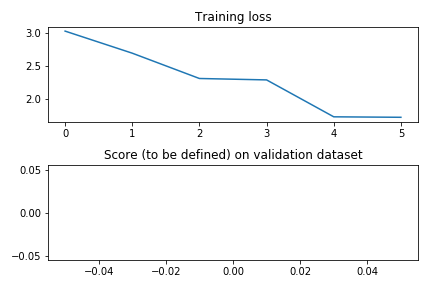

In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt

# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []
 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('Score (to be defined) on validation dataset')

plt.tight_layout()

In [4]:
fcn = resnet_dilated.Resnet34_8s(num_classes=descriptor_dimensionality)
fcn.cuda()
fcn.train()

# note: the softmax happens inside the CrossEntropyLoss
criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [5]:
import time

best_validation_score = 0

iter_size = 20

for epoch in range(130):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        start = time.time()
        
        # get the inputs
        img, anno = data
        print "img shape is", img.shape
        print "img actually is is"
        print img[0,1,:,:]        
        # img is 10 x 3 x 513 x 513 (10 was batch size, 3 is for RGB)
        # anno is 10 x 513 x 513 (same as above, but no rgb)
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda()), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, loss_current_iteration)

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=descriptor_dimensionality)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)# + ponder_cost.sum() * 0.1
        loss.backward()
        optimizer.step()
        
        print time.time() - start, " seconds on gpu " + os.environ["CUDA_VISIBLE_DEVICES"]

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 2 == 1:
            
            
            loss_history.append(running_loss / 2)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
            
        

print('Finished Training')

img shape is torch.Size([4, 3, 513, 513])
img actually is is

-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
          ...             ⋱             ...          
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
[torch.FloatTensor of size 513x513]



/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


1.16795110703  seconds on gpu 0
img shape is torch.Size([4, 3, 513, 513])
img actually is is

-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
          ...             ⋱             ...          
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
[torch.FloatTensor of size 513x513]

0.525836229324  seconds on gpu 0
img shape is torch.Size([4, 3, 513, 513])
img actually is is

-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
          ...             ⋱             ...          
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
-2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
[torch.FloatTensor

Process Process-3:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-2:
Process Process-4:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/da

KeyboardInterrupt: 